Zhiting Zhou 11/13/2023

In [173]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import networkx as nx

In [174]:
# variables
brown = 0
purple = 1

num_agents = 1000
monte_carlo = 10
random_seed = 1

In [175]:
# individual agent's policy
def policy(states=None, func=None, impacted_by_portion=None, confidence=None, impact_from_others=[], cost_of_state=None):
    rt_value = 0 # assume the agent returns brown if no other condition speficied
    prob_purple = 0
    
    def f(x):
        if func != None:
            result = func(x)
        else: 
            result = math.pow(x, 4)
        return result
    
    if impacted_by_portion != None:
        portion_purple = sum(states) / len(states)
        prob_purple = f(portion_purple)
    
    if confidence != None:
        if confidence > 1 or confidence < 0:
            print('confidence level need to be between 0 and 1')
        else:
            prob_purple = (1-confidence) * prob_purple
        
    # if impact_from_others.shape != 0:
    #     if impact_from_others.shape[1] != len(states):
    #         print("the length of impact should equal to the length of states")
    #     # if sum(impact_from_others) > 1:
    #     #     print("impact factros too large")
    #     else:
    #         weighted_states = impact_from_others * states
    #         prob_purple = f(weighted_states)
            
    if cost_of_state != None:
        (state, cost) = cost_of_state # state is set to be purple for now
        prob_purple = (1-cost) * prob_purple
        
    prob_brown = 1 - prob_purple    
    
    p = random.uniform(0, 1)

    if p > prob_purple:
        rt_value = 0
    else:
        rt_value = 1

    return rt_value
        
    

In [176]:
def generate_states(num_agents, num_purple=None):
    if num_purple > num_agents: # Check if the input is valid
        return "m should not be greater than n"
    states = [1] * num_purple + [0] * (num_agents - num_purple)  # List with m zeros and (n-m) ones
    random.shuffle(states)
    return states


In [177]:
def linear(x):
    return x

In [178]:
def simulation(num_agents=1000, depends_on_past_states=True, past_states=None, 
               func=None, impacted_by_portion=None, confidence=None, impact_from_others=None, cost_of_state=None):
    current_states = past_states
    for i in range(num_agents):
        if past_states[i] == 1: # it is already purple
            # do nothing
            current_states[i] = past_states[i]
        else:
            if depends_on_past_states:
                states = past_states
            else:
                states = current_states
                
            states = np.multiply(impact_from_others[i], states)
            state = policy(states=states, func=func, impacted_by_portion=impacted_by_portion, confidence=confidence, cost_of_state=cost_of_state)
            current_states[i] = state
            
    current_purple = sum(current_states) # how many purple we end up with
    past_purple = sum(past_states)
    increased_purple = current_purple - past_purple
    return current_states, current_purple, increased_purple

In [179]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=100)
    plt.show()


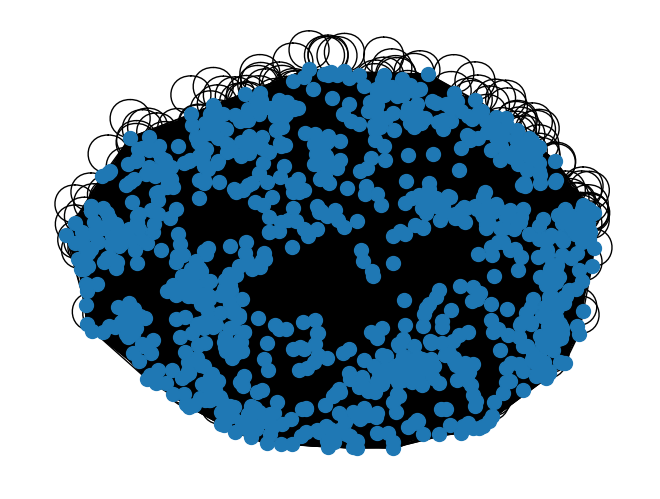

In [180]:
labels = [str(i) for i in range(num_agents)]
adjacency_0 = np.array([[0 for _ in range(num_agents)] for _ in range(num_agents)])
adjacency_1 = np.array([[1 for _ in range(num_agents)] for _ in range(num_agents)])
adjacency_random = np.array([[random.randint(0, 1) for _ in range(num_agents)] for _ in range(num_agents)])

adjacency = adjacency_random
show_graph_with_labels(adjacency)

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

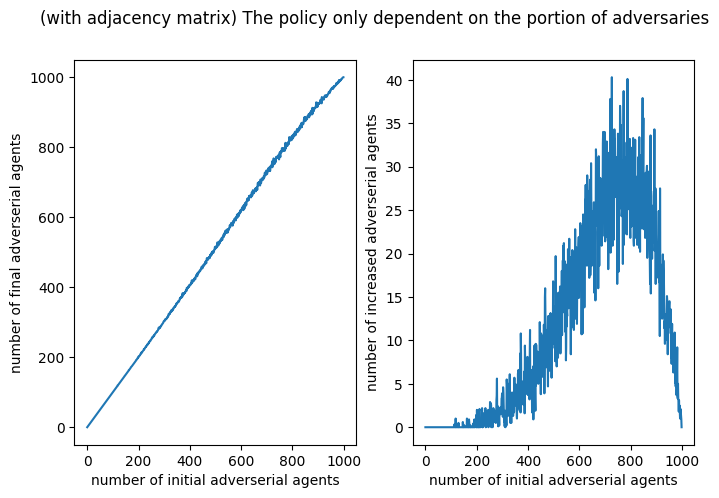

In [181]:
# simulation begins
random.seed(random_seed)
depends_on_past_states = True # if the agent's policy depends on past states or current states?
num_purple = [] # how many purple we end up with
nums = [] # keep track of how many initial purples we tested
num_portion = []
num_increase = []
for num_adv in range(num_agents):
    past_states = generate_states(num_agents=num_agents, num_purple=num_adv) # initial states: i purples, which means i adversaries
    
    # simulate for 10 times
    current_states_carlo = []
    current_purple_carlo = 0
    for iter in range(monte_carlo): 
        current_states, current_purple, increased_purple = simulation(num_agents=num_agents, depends_on_past_states=True,past_states=past_states,
                                                                      func=None, impacted_by_portion=True, confidence=None, impact_from_others=adjacency, cost_of_state=None)
        current_states_carlo = current_states_carlo + current_states
        current_states_carlo = np.array(current_states_carlo)
        current_purple_carlo += current_purple
        
    current_states = [round(num) for num in current_states_carlo/monte_carlo] # make sure the states are binary

    current_purple = current_purple_carlo/monte_carlo
    increased_purple = current_purple - num_adv
        
    num_purple.append(current_purple)
    nums.append(num_adv)
    num_increase.append(increased_purple)
    num_portion.append((sum(current_states) - num_adv) / (sum(past_states)+0.001))

plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple)
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase)
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')
# ax = plt.subplot(1,3,3)
# plt.plot(nums, num_portion)
# plt.xlabel("number of initial adverserial agents")
# plt.ylabel("number of increased adverserial agents")
# plt.title("the policy depends on the portion of answering purple")
    
    

In [182]:
# reward function of each agent